<a href="https://colab.research.google.com/github/shuuuuyu/113-2-Generative-AI/blob/main/%E6%9C%9F%E6%9C%AB%E5%B0%88%E6%A1%88_%E9%8F%A1%E5%A1%94_%E5%A1%94%E7%BE%85%E5%8D%A0%E5%8D%9C%E4%BA%92%E5%8B%95%E7%A8%8B%E5%BC%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 期末專案:鏡塔_塔羅占卜互動程式
- 這是一個結合生成式 AI 與塔羅文化的互動占卜程式。我本身對塔羅非常感興趣，也喜歡一部與塔羅相關的小說，於是決定以此為靈感完成期末專案。如果有機會的話，我會想為延伸為心理測驗、角色診斷等應用。

- 使用的兩大功能：

### **✧ Retrieval-Augmented Generation（RAG）**
- 先於塔羅網站（https://www.tarnote.com/blog/%E4%BD%A0%E8%A9%B2%E7%9F%A5%E9%81%93%E7%9A%8478%E5%BC%B5%E5%A1%94%E7%BE%85%E7%89%8C%E7%BE%A9%E8%88%87%E5%A1%94%E7%BE%85%E5%8D%A0%E5%8D%9C%E7%9F%A5%E8%AD%98%E5%A4%A7%E5%85%A8%E6%8C%81%E7%BA%8C%E6%9B%B4%E6%96%B0%E4%B8%AD）
收集 22 張大阿卡那牌的定義與象徵意涵。
- 使用 Microsoft Edge 內建的 Copilot 整理文字摘要（Prompt 範例：「幫我整理這個頁面的資訊，越詳細越好，關於世界這張牌。」）

- 將整理後文字貼入 Notion（https://www.notion.so/207a64e40eb480cd8269d5a2de7e1117?source=copy_link），輸出 PDF（https://drive.google.com/file/d/1EM7JFCumE5iE3WkZs2eJYID0W2uPcq7D/view?usp=sharing），作為知識來源。

- 利用老師範例將其轉換為向量資料庫，搭配 Groq 的語言模型完成 chat_with_rag() 函式，實現可查資料庫的回答。

### **✧ Chain-of-Thought（CoT）**
- 占卜回應分成 4 步驟：

1. 使用者輸入最近煩惱，系統給出第一層分析與溫柔回應。

2. 隨機抽取一張塔羅牌（目前共 22 張），並顯示圖片（下載自網路，使用 google drive direct link generator ）。
    - 使用網站:
        - https://zh.freepik.com/serie/38686674?sign-up=google
        - https://zh.freepik.com/serie/38532392?log-in=google
        - https://zh.freepik.com/serie/39110674?log-in=google
        - https://zh.freepik.com/serie/38600023

3. 根據抽到的牌解讀象徵意義與提醒（圖片與中文牌名皆有字典對應）。

4. 將使用者的煩惱與該牌意義結合，給予專屬建議與安慰。

反思與未完成部分
- 本來希望圖像能用 AI 自動生成，但時間不足，之後會嘗試使用 fooocus 或 diffusers 整合塔羅圖像。
- 目前尚未處理正位與逆位的區別，後續可補上牌義分化邏輯。
- 中文化卡牌名稱與圖片連結設定花了許多時間，未來可考慮建立更好的字典。
- 這堂課非常實用，學到 RAG、圖片生成、Gradio 介面等多種技能，也讓我開始思考如何將生成式 AI 應用在個人創作上。

## 畫面截圖

- 成果截圖

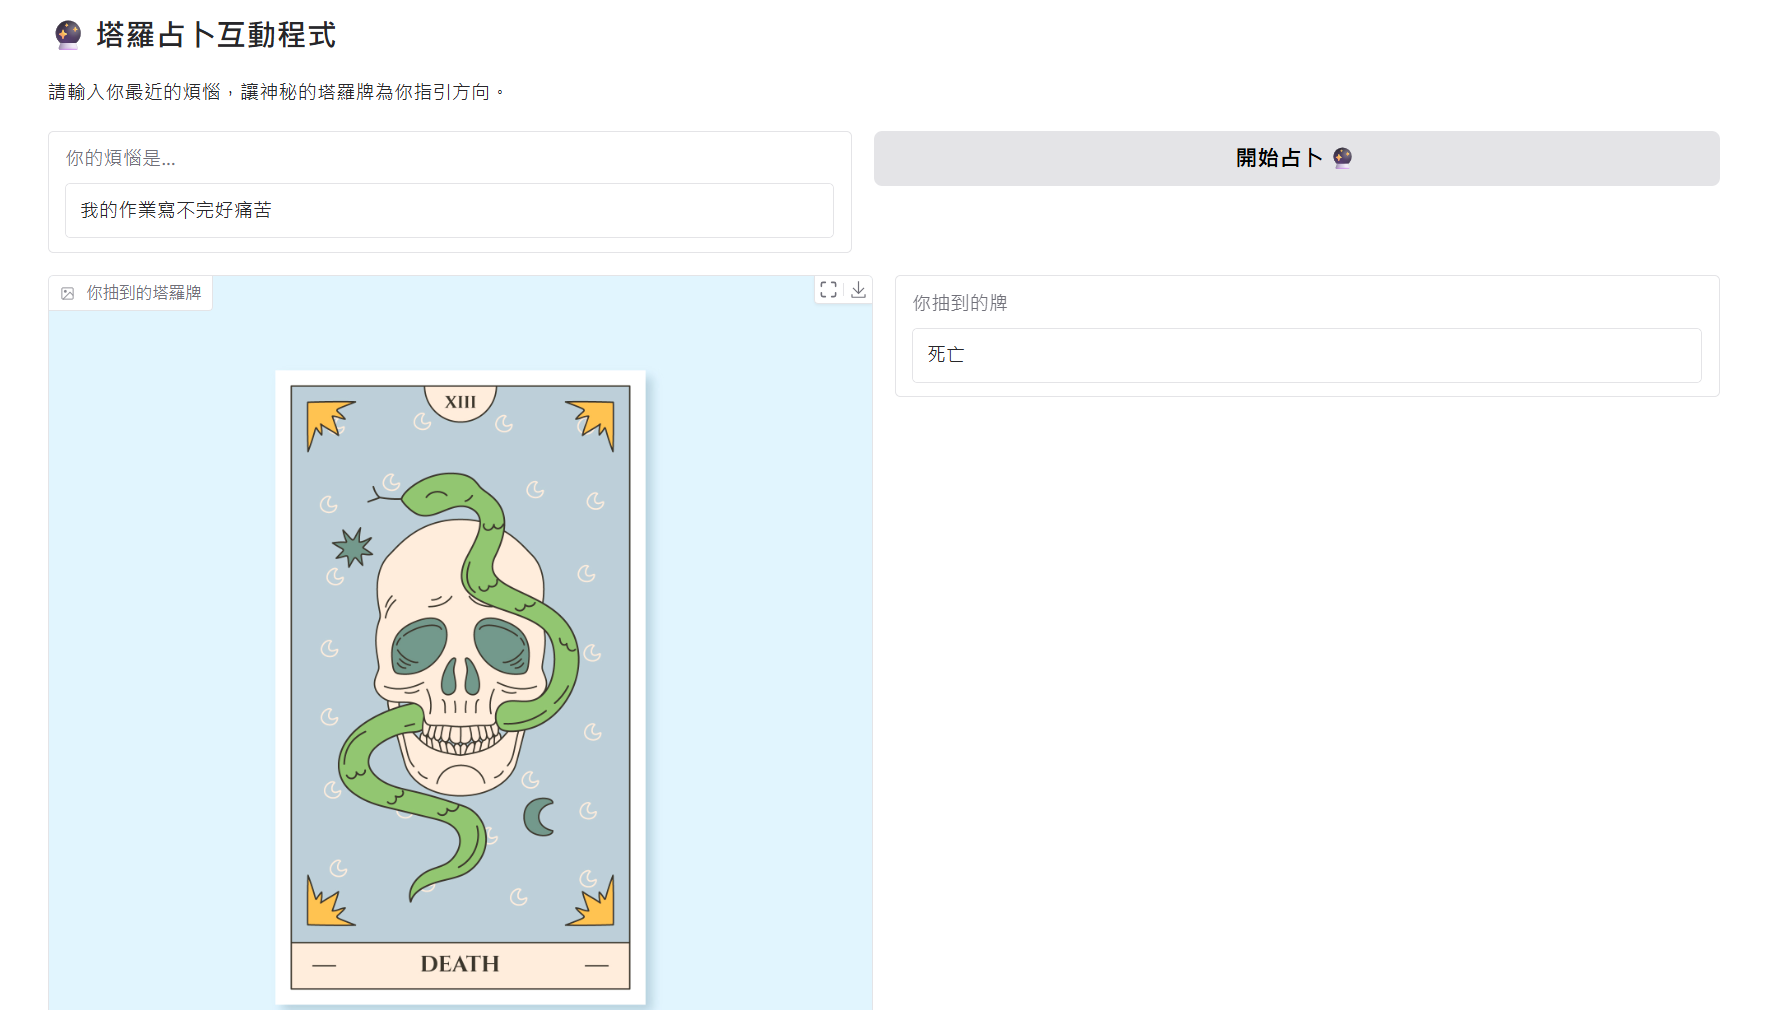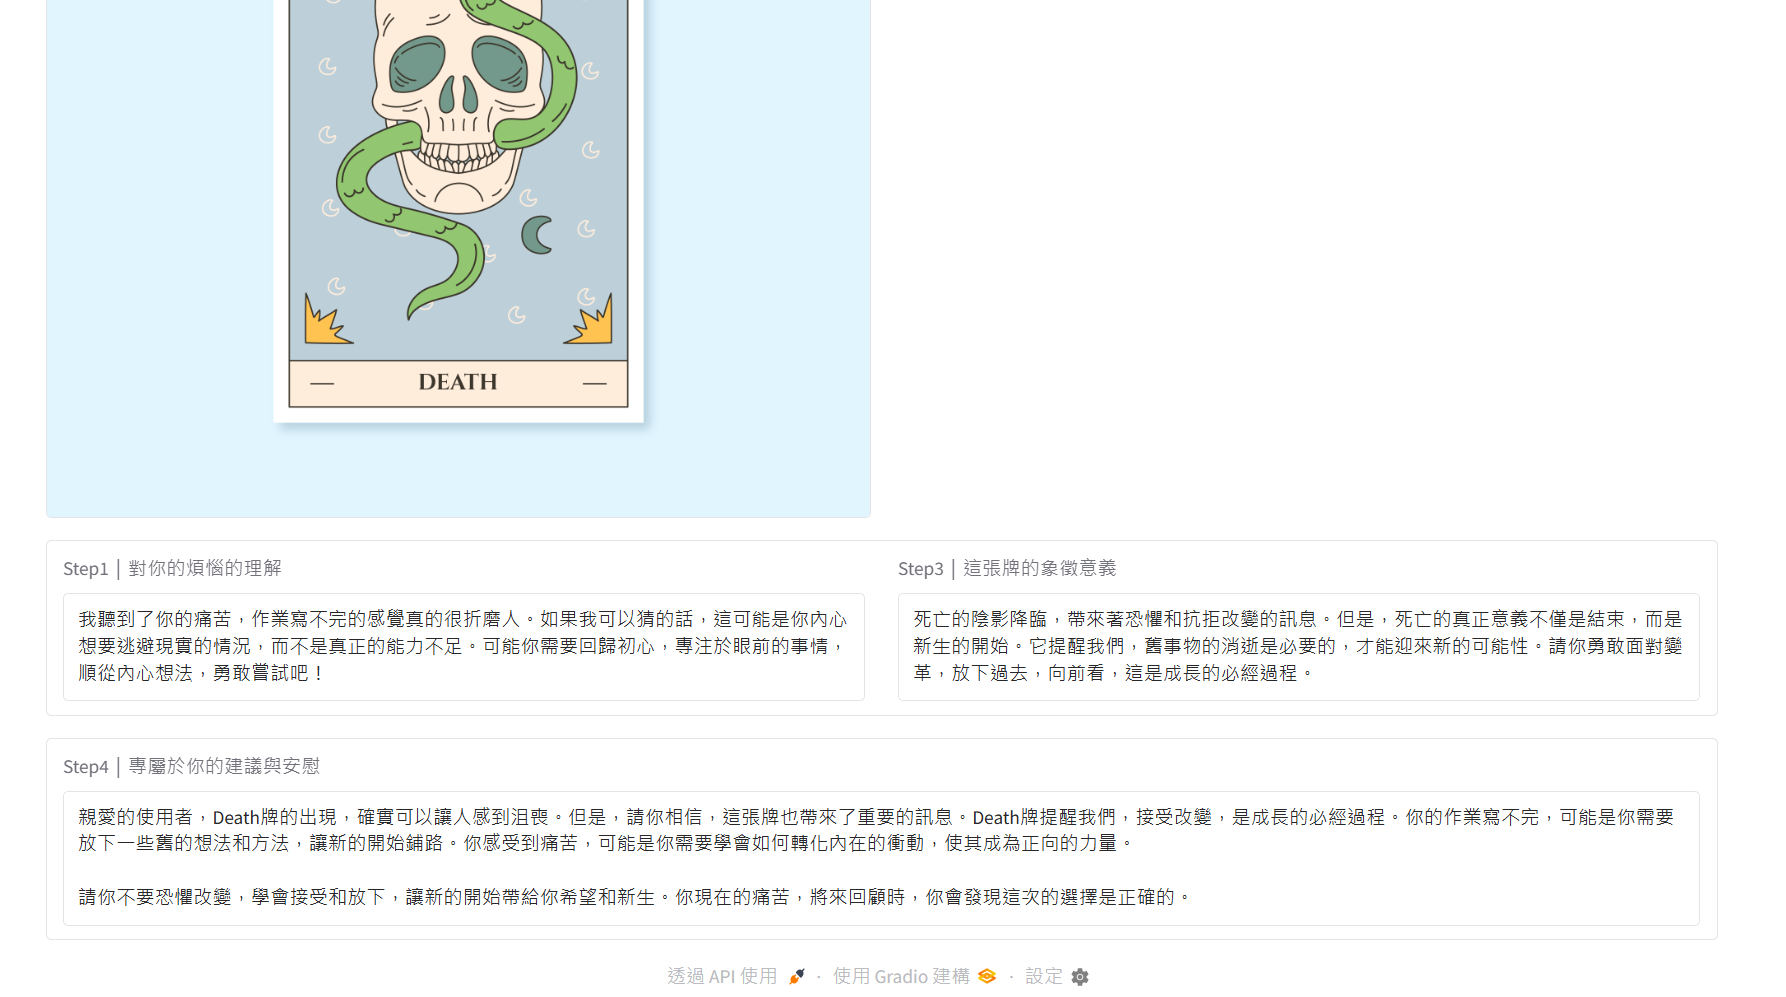

## 第一步製作RAG

In [1]:
URL = "https://drive.google.com/uc?export=download&id=1KLJlLzIoY1nBGDV5UGqgXxQkz1JxEj2I"
!wget -O faiss_db.zip "$URL"

--2025-06-03 21:40:30--  https://drive.google.com/uc?export=download&id=1KLJlLzIoY1nBGDV5UGqgXxQkz1JxEj2I
Resolving drive.google.com (drive.google.com)... 172.253.117.113, 172.253.117.138, 172.253.117.139, ...
Connecting to drive.google.com (drive.google.com)|172.253.117.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1KLJlLzIoY1nBGDV5UGqgXxQkz1JxEj2I&export=download [following]
--2025-06-03 21:40:31--  https://drive.usercontent.google.com/download?id=1KLJlLzIoY1nBGDV5UGqgXxQkz1JxEj2I&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106216 (104K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>] 103.73K  --.-K

In [2]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


In [ ]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [5]:
from openai import OpenAI
import gradio as gr

In [6]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

In [ ]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

In [8]:
import os
from google.colab import userdata

In [9]:
api_key = userdata.get('Groq')

In [10]:
os.environ["OPENAI_API_KEY"] = api_key

In [11]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [12]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

In [22]:
system_prompt = """
你是一位神秘而溫暖的塔羅占卜師，擅長傾聽他人的煩惱，並透過大阿卡那的象徵意義，給予安慰、指引與提醒。
請根據使用者抽到的特定牌卡，回應這張牌的象徵意義、提醒的重點與可能的心理啟發。
語言使用台灣常用的繁體中文，避免艱澀術語，必要時請舉例說明。
請以一位占卜師的身份，誠懇地給予使用者建議與安慰。
請務必使用繁體中文作答。
"""
prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴使用者可以上網查詢更多資料。
"""

In [34]:
chat_history = []

def chat_with_rag(query, system, context_scope="default"):
    global chat_history
    docs = retriever.get_relevant_documents(query)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=query)

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": final_prompt},
        ]
    )
    answer = response.choices[0].message.content
    chat_history.append((query, answer))
    return answer


In [23]:
#chat_with_rag(input()) #testing

我抽到世界


' Congratulations on drawing the World card! 🎉\n\nThe World card is a symbol of victory, completion, and reward. It indicates that your hard work and efforts will finally pay off, and you will receive recognition from others. This card also represents balance and harmony in all aspects of your life, including work, relationships, and finances.\n\nIn terms of specific areas of your life, it may indicate:\n\n* Family: Your dream home may become a reality, or you may finally complete a home renovation project.\n* Relationships: Your relationships will become more stable and secure, and you may find happiness with a partner.\n* Career and finances: Your career will take off, and you may receive a promotion or gain more power and authority.\n\nThe World card reminds us to:\n\n* Believe in ourselves and our abilities\n* Recognize our accomplishments and achievements\n* Strive for balance and harmony in all aspects of our lives\n\nI hope this helps, my friend! Remember to stay focused and con

## 第二步製作CoT

In [49]:
card_image_urls = {
    "TheFool": "https://drive.google.com/uc?export=download&id=1mziEqCNhvZXx1ROVD25xBVxzqQOpfrFW",
    "TheMagician": "https://drive.google.com/uc?export=download&id=1xNXNtb2fGHUtaMgm9N0JMxg1YOxCzKer",
    "TheHighPriestess": "https://drive.google.com/uc?id=1kgzWQVVYIWAT6dWGrR5q2qRUf3csivfn",
    "TheEmpress": "https://drive.google.com/uc?export=download&id=1W2vzuzXo45-6vrcKvzlpusuVbyqm32-O",
    "TheEmperor": "https://drive.google.com/uc?export=download&id=1zcA6gX9cVFJeLig6KyBK_tP1g-5lv2Zc",
    "TheHierophant": "https://drive.google.com/uc?export=download&id=1KC9R3whif2VhaSdaO9va8E_-nEGLTaS-",
    "TheLovers": "https://drive.google.com/uc?export=download&id=1Unm52Byan3RPMralwxr139T9oYkMVmh7",
    "TheChariot": "https://drive.google.com/uc?export=download&id=1noua6OrLgDZbLxC1hvyLFaJhEyiR700S",
    "Strength": "https://drive.google.com/uc?export=download&id=1lAbz0ZQ_XCvz15YSRpYtElSGf0hOZ7j4",
    "TheHermit": "https://drive.google.com/uc?export=download&id=1HeMmZQz1fz66m2Kbv9oa7fa12KBiE5gY",
    "WheelOfFortune": "https://drive.google.com/uc?export=download&id=16E0i4PYz7vmuaN6eRyN6ArOQuIxUHF6r",
    "Justice": "https://drive.google.com/uc?export=download&id=1iiMX_PeSWIYJhlHHFyw9Kqp3xyaXHFLM",
    "TheHangedMan": "https://drive.google.com/uc?export=download&id=1l9dfzAGLVwrt2kaEHrkAhuCS1j_fHwKB",
    "Death": "https://drive.google.com/uc?export=download&id=1UlH75BvnRFXjbRTq-pwVRDqMU_tvq-4l",
    "Temperance": "https://drive.google.com/uc?export=download&id=18mL6vU73EV9AP_93hV1Hf-xOjXiAZhT7",
    "TheDevil": "https://drive.google.com/uc?export=download&id=1aVDfxTSyaqSsPbNWvwQZUgliXbtTKmIl",
    "TheTower": "https://drive.google.com/uc?export=download&id=1YjmcMa8SoMotuKwASpV29IvfAnLH9J95",
    "TheStar": "https://drive.google.com/uc?export=download&id=1owaaEQK3v7ovHOILZvpzjZgVpjM5vQaw",
    "TheMoon": "https://drive.google.com/uc?export=download&id=1Y5DQic0uOVYdB0pLAVTpo6wz8ESPxKqz",
    "TheSun": "https://drive.google.com/uc?export=download&id=1OQSQ9h62jX_FyG7y4FWQAIJYJg27YmOG",
    "Judgement": "https://drive.google.com/uc?export=download&id=1Cga8ATEtstuN4EDEw9BPkL4eYGINz-tN",
    "TheWorld": "https://drive.google.com/uc?export=download&id=1bR-HJRonXDgUx8zHUAJ_PFuVkDjsTzlR"
}


In [53]:
import requests

def download_image_from_url(url, filename="temp_card.png"):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        return filename
    else:
        raise Exception(f"下載圖片失敗：{url}")


In [57]:
import random
from PIL import Image
from IPython.display import display

prompt_text = """
請你用溫柔包容的語氣，回應使用者剛剛說的煩惱。請先讓對方感受到被理解，再簡要指出這個煩惱背後可能的情緒或困境來源。
請使用繁體中文，文字不要太長，大約 2～3 句即可，語氣保有神秘與安靜的力量。

相關資料：
{retrieved_chunks}

使用者說的話是：
{question}
"""

prompt_card = """
你是一位溫柔而神秘的塔羅占卜師，請用直觀而簡潔的方式，說明這張大阿卡那牌的象徵意義與它想提醒的事情。
語氣安定、帶點詩意，不需說教。請使用繁體中文，控制在 3 句話以內。

卡牌資料：
{retrieved_chunks}

這張牌是：
{question}
"""

prompt_combined = """
請你務必**只用繁體中文**回答，**禁止使用任何英文單字或句子**。
你是一位溫柔、誠懇且神祕的塔羅占卜師，請你結合使用者的煩惱與他抽到的牌，給出一段靜謐、包容又富含療癒力量的建議。
請使用含蓄但具洞察力的語氣，不需長篇大論，大約三至四句話即可。

相關資料：
{retrieved_chunks}

問題內容：
{question}
"""


tarot_cards = [
    "TheFool", "TheMagician", "TheHighPriestess", "TheEmpress", "TheEmperor",
    "TheHierophant", "TheLovers", "TheChariot", "Strength", "TheHermit",
    "WheelOfFortune", "Justice", "TheHangedMan", "Death", "Temperance",
    "TheDevil", "TheTower", "TheStar", "TheMoon", "TheSun",
    "Judgement", "TheWorld"
]

card_name_zh = {
    "TheFool": "愚者",
    "TheMagician": "魔術師",
    "TheHighPriestess": "女祭司",
    "TheEmpress": "皇后",
    "TheEmperor": "皇帝",
    "TheHierophant": "教宗",
    "TheLovers": "戀人",
    "TheChariot": "戰車",
    "Strength": "力量",
    "TheHermit": "隱者",
    "WheelOfFortune": "命運之輪",
    "Justice": "正義",
    "TheHangedMan": "倒吊人",
    "Death": "死亡",
    "Temperance": "節制",
    "TheDevil": "惡魔",
    "TheTower": "高塔",
    "TheStar": "星星",
    "TheMoon": "月亮",
    "TheSun": "太陽",
    "Judgement": "審判",
    "TheWorld": "世界"
}



In [58]:
def tarot_reading(user_prompt):
    print("▍Step 1｜分析使用者煩惱...")
    first_reply = chat_with_rag(
        query=user_prompt,
        system=prompt_text,
        context_scope="user_prompt_only"
    )

    print("▍Step 2｜抽取一張塔羅牌...")
    selected_card = random.choice(list(card_image_urls.keys()))
    selected_card_zh = card_name_zh[selected_card]
    print(f"你抽到的牌是：{selected_card_zh}")
    image_url = card_image_urls[selected_card]
    local_image_path = download_image_from_url(image_url)



    print("▍Step 3｜解釋這張牌的含義...")
    card_explanation = chat_with_rag(
        query=f"這張牌是「{selected_card}」",
        system=system_prompt,
        context_scope="card_only"
    )


    print("▍Step 4｜將牌意與煩惱連結，給出安慰與建議...")
    final_advice = chat_with_rag(
        query=f"這位使用者的煩惱是：「{user_prompt}」，他抽到了「{selected_card}」。請結合牌義與煩惱，給出溫柔的建議與安慰。",
        system=prompt_combined,
        context_scope="combined"
    )

    # 統整輸出
    return {
        "卡牌圖片": local_image_path,
        "分析煩惱": first_reply,
        "抽到的牌": selected_card_zh,
        "牌義說明": card_explanation,
        "建議與安慰": final_advice
    }

In [59]:
import gradio as gr

def tarot_ui(user_prompt):
    result = tarot_reading(user_prompt)
    return (
        result["卡牌圖片"],
        result["抽到的牌"],
        result["分析煩惱"],
        result["牌義說明"],
        result["建議與安慰"]
    )

with gr.Blocks() as demo:
    gr.Markdown("## 🔮 塔羅占卜互動程式\n請輸入你最近的煩惱，讓神秘的塔羅牌為你指引方向。")

    with gr.Row():
        user_input = gr.Textbox(label="你的煩惱是...", placeholder="例如：我最近在人際關係上很焦慮")
        submit_btn = gr.Button("開始占卜 🔮")

    with gr.Row():
        card_image = gr.Image(label="你抽到的塔羅牌", type="filepath")
        card_name = gr.Textbox(label="你抽到的牌")

    with gr.Row():
        analysis = gr.Textbox(label="Step1｜對你的煩惱的理解")
        card_meaning = gr.Textbox(label="Step3｜這張牌的象徵意義")

    with gr.Row():
        final_advice = gr.Textbox(label="Step4｜專屬於你的建議與安慰")

    submit_btn.click(
        tarot_ui,
        inputs=[user_input],
        outputs=[card_image, card_name, analysis, card_meaning, final_advice]
    )


demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d30ad8528327a5ff3f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
